# Working with diffussion models: Arbitrary Image Manipulation

In this project the capabilities of diffussion models should be discovered, with the help of a web app that dynamically allows to swap out the background of a subject and substitute it with an image generated by Stable Diffusion through a text prompt:

__Note__: this requires a large amount of GPU-memory, a GeForce GTX 1050 Ti with 4 GB won't be sufficient in order to run the models for segmentation and diffusion

In [1]:
from PIL import Image
import requests
from transformers import SamModel, SamProcessor
from diffusers import DiffusionPipeline, AutoPipelineForText2Image, AutoPipelineForInpainting
from diffusers.utils import load_image, make_image_grid

import torch
import numpy as np

## SAM

Given any input image, as a first step the object of interested needs to be defined. In order to operate on arbitrary image data, this requires a rather robust segmentation. [Segment-Anything-Model](https://segment-anything.com/) (short: SAM) has shown a reliable outcome of such estimates and since it is publicly available over huggingface, this algorithm will be picked and prepared below.

This cell might take a couple of minutes to load.

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = SamModel.from_pretrained("facebook/sam-vit-huge").to(device)
processor = SamProcessor.from_pretrained("facebook/sam-vit-huge")

### Retrieve the segmentation mask

After SAM has been loaded, it can be used to extract the segmentation mask, the output given of any image and few selection points

In [3]:
def mask_to_rgb(mask):
    """
    Transforms a binary mask into an RGBA image for visualization
    """
    
    bg_transparent = np.zeros(mask.shape + (4, ), dtype=np.uint8)
    
    # Specify selection-overdub color
    bg_transparent[mask == 1] = [0, 255, 0, 127]  # (r, g, b, a)
    
    return bg_transparent


def get_processed_inputs(image, input_points):
    """
    Extracts the segmentation mask from a given image and the input_points localizing the object of interest
    """
    inputs = processor(image, input_points=input_points, return_tensors="pt").to(device)
    
    # Call SAM
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Call post-processing of the SAM-outputs to obtain the masks
    masks = processor.image_processor.post_process_masks(
       outputs.pred_masks.cpu(), 
       inputs["original_sizes"].cpu(), 
       inputs["reshaped_input_sizes"].cpu()
    )
    
    # Select most likliest mask
    best_mask = masks[0][0][outputs.iou_scores.argmax()] 

    # Ultimately, the mask is being inverted, that the object gets assigned
    # with 0 and the background in turn with 1.
    return ~best_mask.cpu().numpy()

Since segmentation is now prepared, it's time to evaluate 
if it's operating as expected. Given the following input image

<img src='car.png' width="200px"></img>

and when the input points cover the area of the car, 
then the mask should look similar to this

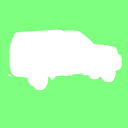

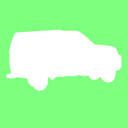

In [4]:
raw_image_test = Image.open("car.png").convert("RGB").resize((512, 512))
input_points_test = [[[150, 170], [300, 250]]]

mask_test = get_processed_inputs(raw_image_test, input_points_test)
Image.fromarray(mask_to_rgb(mask_test)).resize((128, 128))

## Inpainting

After SAM works properly it's time to prepare the diffusion model inference.

In [ ]:
pipeline = AutoPipelineForInpainting.from_pretrained(
   "diffusers/stable-diffusion-xl-1.0-inpainting-0.1",
    torch_dtype=torch.float16
).to(device)

# This might make it work more efficient on the hardware
pipeline.enable_model_cpu_offload()

Fetching 18 files:   0%|          | 0/18 [00:00<?, ?it/s]

Since the pipeline should now be loaded, to facilitate the experiments, first a common interface is generated

In [ ]:
def inpaint(raw_image, input_mask, prompt, negative_prompt=None, seed=74294536, cfgs=7):
    """
    Takes the vanilla input image, utilizes the segmentation mask as selection indication and 
    calls the diffusion model interference in order to manipulate the sub-part of the image.
    """
    
    mask_image = Image.fromarray(input_mask)
    
    rand_gen = torch.manual_seed(seed)
    
    image = pipeline(
        image=raw_image,
        mask_image=mask_image,
        prompt=prompt,
        negative_prompt=negative_prompt if (negative_prompt is not None) else [],
        rand_gen=rand_gen,
        cfgs=cfgs
    ).images[0]
    
    return image

It's time to test it on the mask that was obtained earlier with SAM:

In [ ]:
prompt_test = "a car driving on Mars. Studio lights, 1970s"
negative_prompt_test = "artifacts, low quality, distortion"

image = inpaint(raw_image_test, mask_test, prompt_test, negative_prompt_test)

A look on the results (from left to right: _raw image, segmentation mask, manipulated image_)

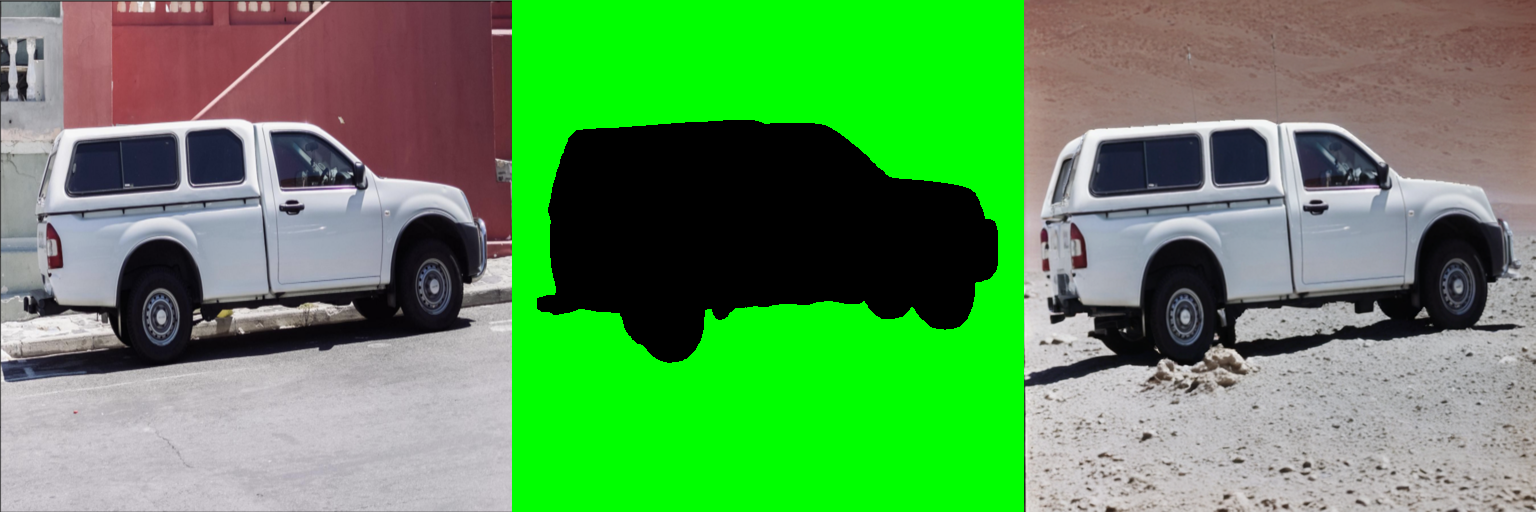

In [8]:
fig = make_image_grid([raw_image_test, Image.fromarray(mask_to_rgb(mask_test)), image.resize((512, 512))], rows=1, cols=3)
fig

## Interactive app

As announced, with the help of a web app the experiments can be held more dynamically. It takes the code prepared and adds on top a GUI for image selection and point localization.

To run it, execute the subsequent cell and navigate to the URL that will be prompted once it is ready. There might also be case that the UI is run within a jupyter cell, but it is a less convenient way of operating.

In [9]:
import app

In [10]:
my_app = app.generate_app(get_processed_inputs, inpaint)

Running on local URL:  http://127.0.0.1:7860
IMPORTANT: You are using gradio version 3.50.2, however version 4.44.1 is available, please upgrade.
--------
Running on public URL: https://899757349a9c6c6381.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


<PIL.Image.Image image mode=1 size=512x512 at 0x7881B9802B60>
<PIL.Image.Image image mode=1 size=512x512 at 0x7881B9789AE0>


  0%|          | 0/49 [00:00<?, ?it/s]

<PIL.Image.Image image mode=1 size=512x512 at 0x7881B9802B60>


  0%|          | 0/49 [00:00<?, ?it/s]

<PIL.Image.Image image mode=1 size=512x512 at 0x7881B98026B0>
<PIL.Image.Image image mode=1 size=512x512 at 0x7881BAA229B0>


  0%|          | 0/49 [00:00<?, ?it/s]

<PIL.Image.Image image mode=1 size=512x512 at 0x78863A5ED0F0>
<PIL.Image.Image image mode=1 size=512x512 at 0x78863A5ED1B0>


  0%|          | 0/49 [00:00<?, ?it/s]

<PIL.Image.Image image mode=1 size=512x512 at 0x7881B8E5A050>


  0%|          | 0/49 [00:00<?, ?it/s]

<PIL.Image.Image image mode=1 size=512x512 at 0x7881B8E4AC20>


  0%|          | 0/49 [00:00<?, ?it/s]

<PIL.Image.Image image mode=1 size=512x512 at 0x7881B98025F0>
<PIL.Image.Image image mode=1 size=512x512 at 0x7881B8EDFD90>


  0%|          | 0/49 [00:00<?, ?it/s]

<PIL.Image.Image image mode=1 size=512x512 at 0x7881B9789B10>


  0%|          | 0/49 [00:00<?, ?it/s]

<PIL.Image.Image image mode=1 size=512x512 at 0x7881BA962500>


  0%|          | 0/49 [00:00<?, ?it/s]

<PIL.Image.Image image mode=1 size=512x512 at 0x7881B9800280>


  0%|          | 0/49 [00:00<?, ?it/s]

<PIL.Image.Image image mode=1 size=512x512 at 0x7881BA962500>


  0%|          | 0/49 [00:00<?, ?it/s]

<PIL.Image.Image image mode=1 size=512x512 at 0x7881B8F013F0>
<PIL.Image.Image image mode=1 size=512x512 at 0x7881B8EDE3B0>
<PIL.Image.Image image mode=1 size=512x512 at 0x7881B8E49000>


  0%|          | 0/49 [00:00<?, ?it/s]

<PIL.Image.Image image mode=1 size=512x512 at 0x7881BAA21FC0>


  0%|          | 0/49 [00:00<?, ?it/s]

<PIL.Image.Image image mode=1 size=512x512 at 0x7881B8E59990>


  0%|          | 0/49 [00:00<?, ?it/s]

Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://899757349a9c6c6381.gradio.live


In [11]:
my_app.close()

Closing server running on port: 7860


## Experiments

### Evolutionary usage

With the help of the app, walking on water is feasible. 

__( 1 ) As a humble beginning, the floor is selected and prompted with "water"__

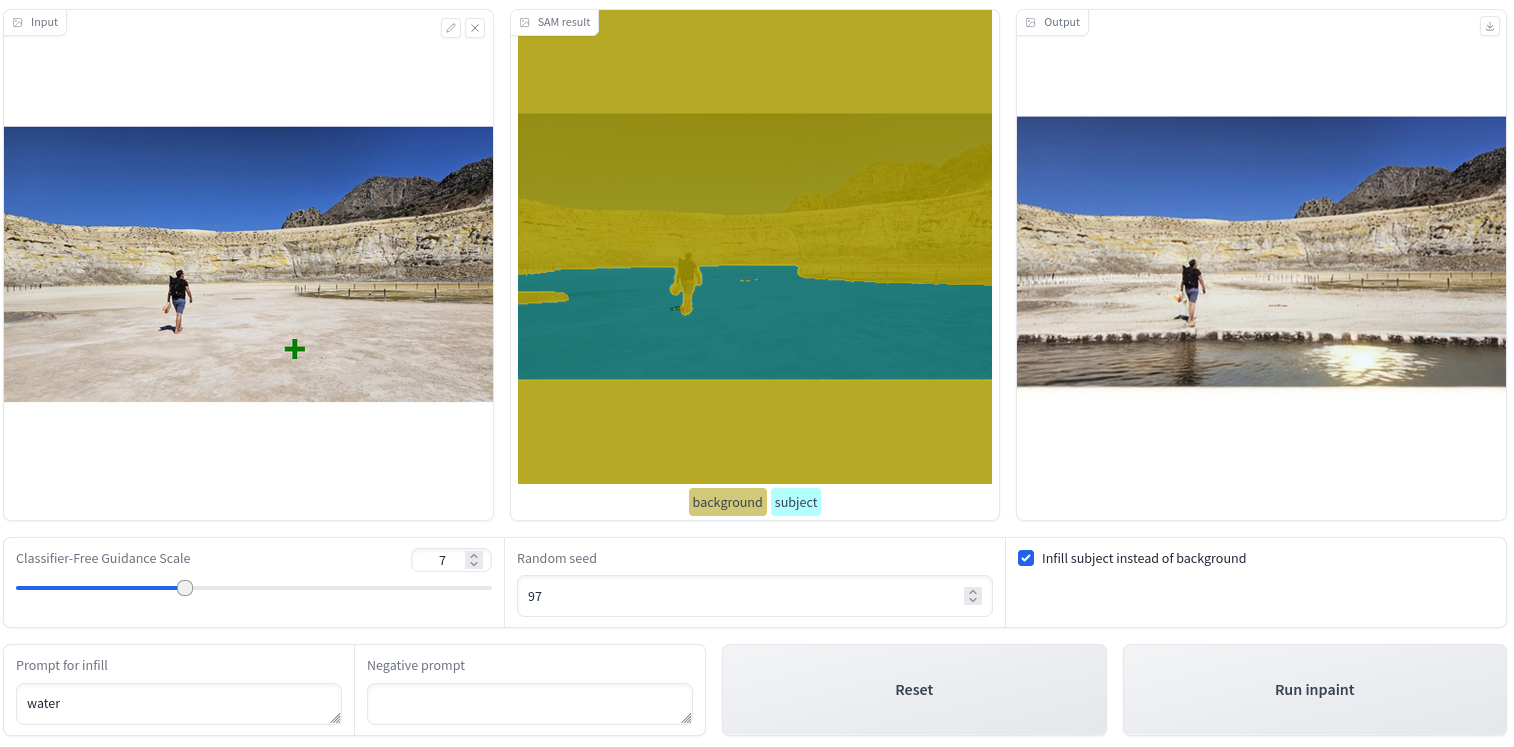

Apparently it understood the concept but added a beach like scenario - the target is not achieved. Hence


__( 2 ) Add a negative prompt to refrain from `ground` and `beach`__

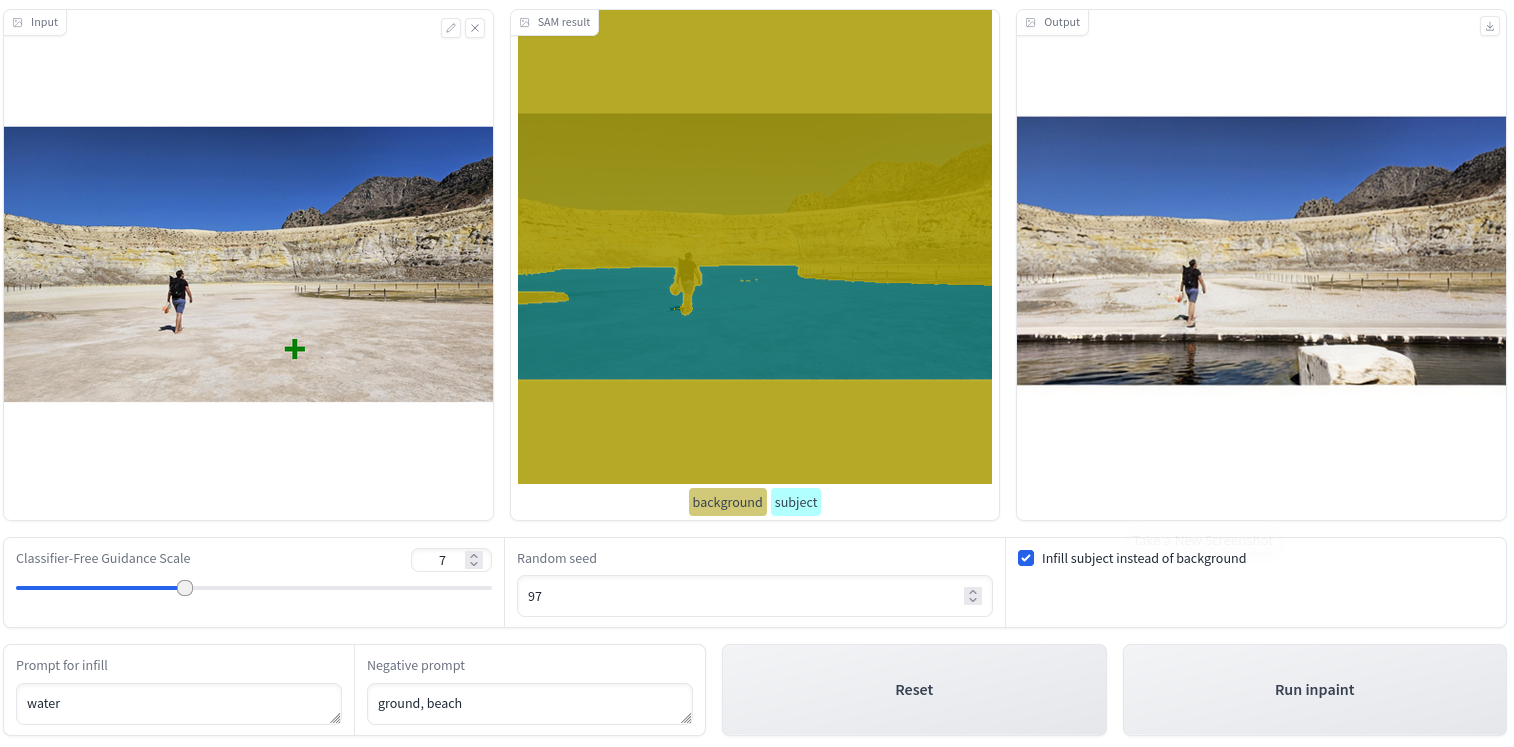

for the part it was editing, the solid ground was removed but it ignored the more distant area. Hence

__( 3 ) Adjust CFGS__

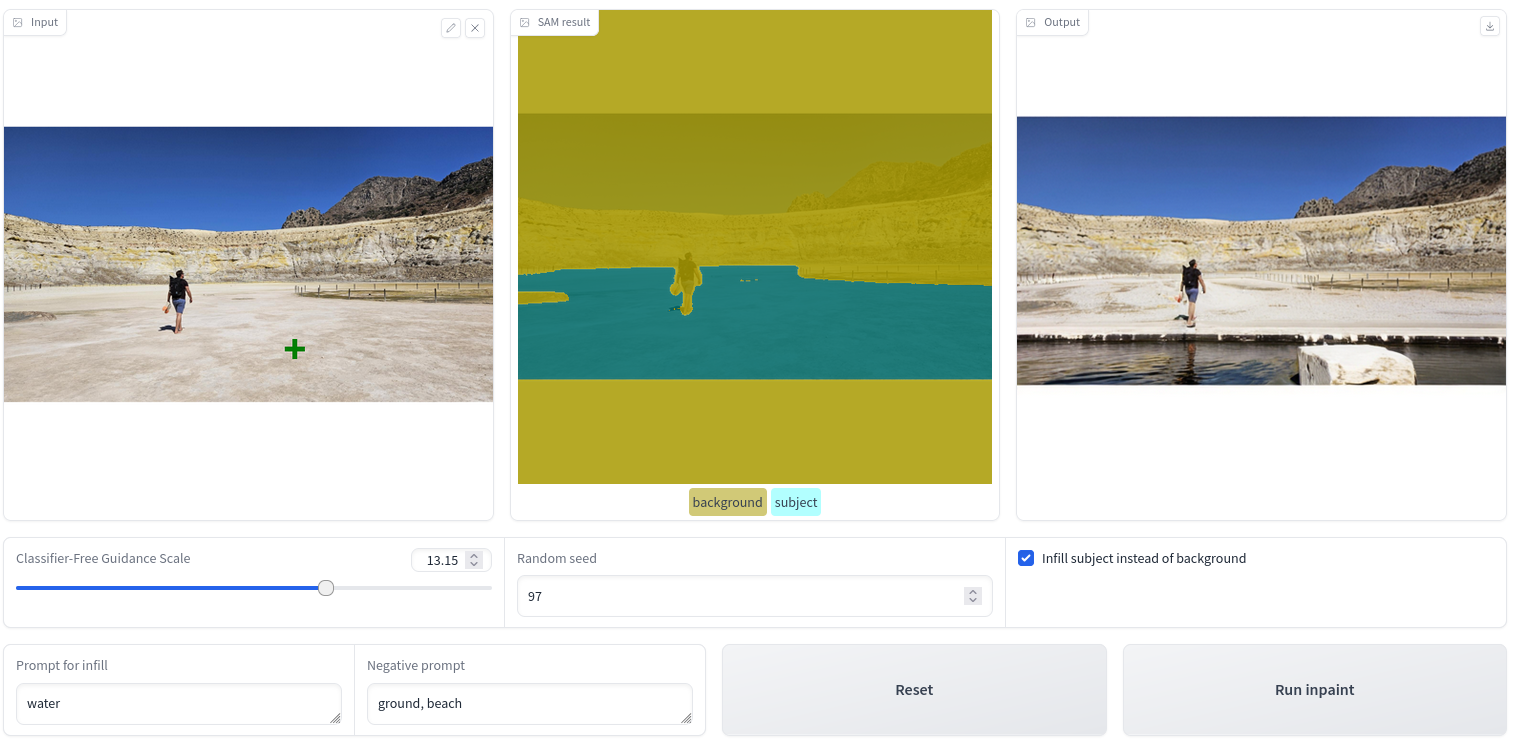

as it seemd to move in the right direction, an experiment with changing the scale of classifier-free guidance was made but it still did not yield the desired experiments. Hence

__( 4 ) Experiment with another prompt__

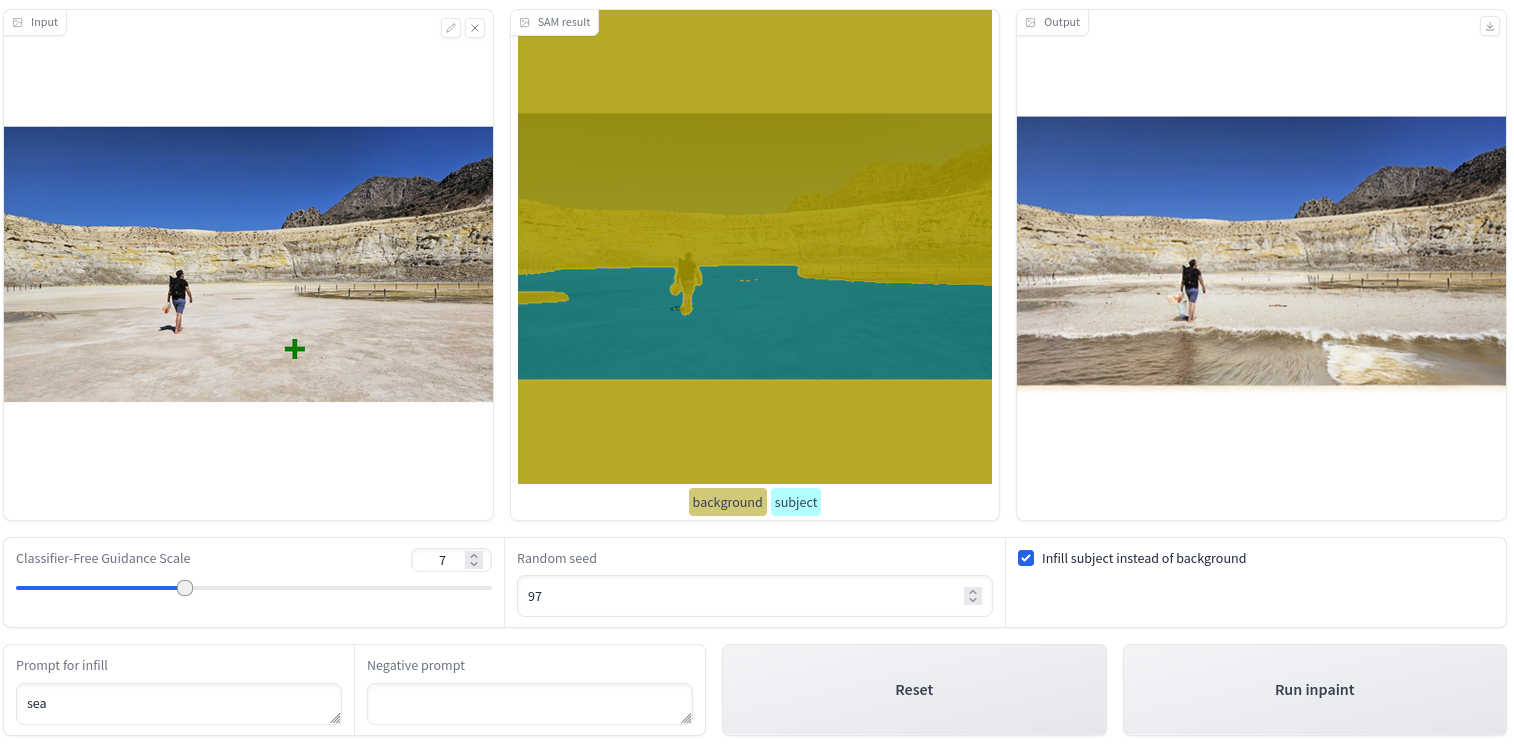

`Water` is an arbitrary expression it could mean for instance river streams, drinks, pools. A more streamlined expression for our case probably is using `sea` instead but couldn't succeed with it again. Hence

__( 5 ) Describe the cause__

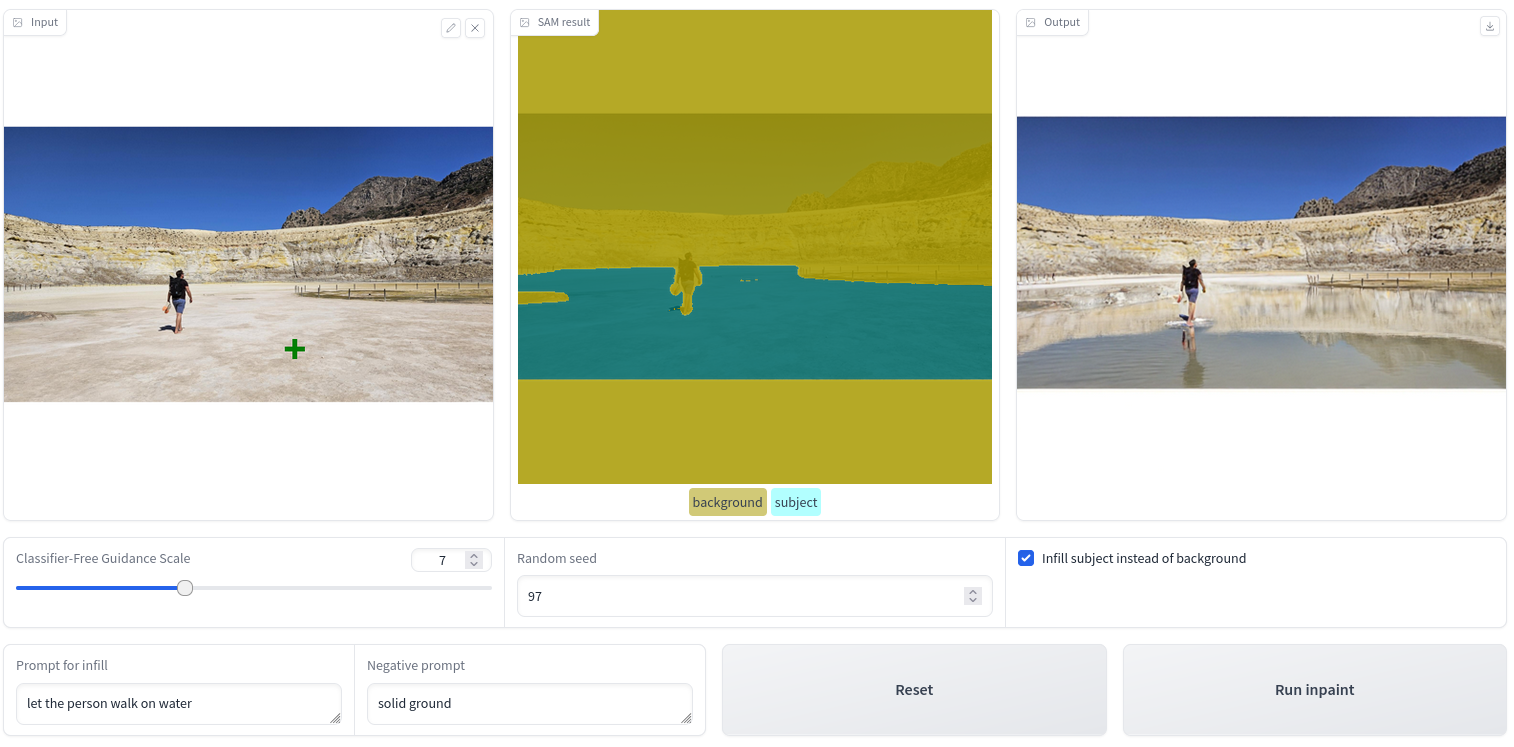

When refraining from using one single word as target object and rather describe what should happen with this area the goal is finally achieved

### Arbitrary Examples

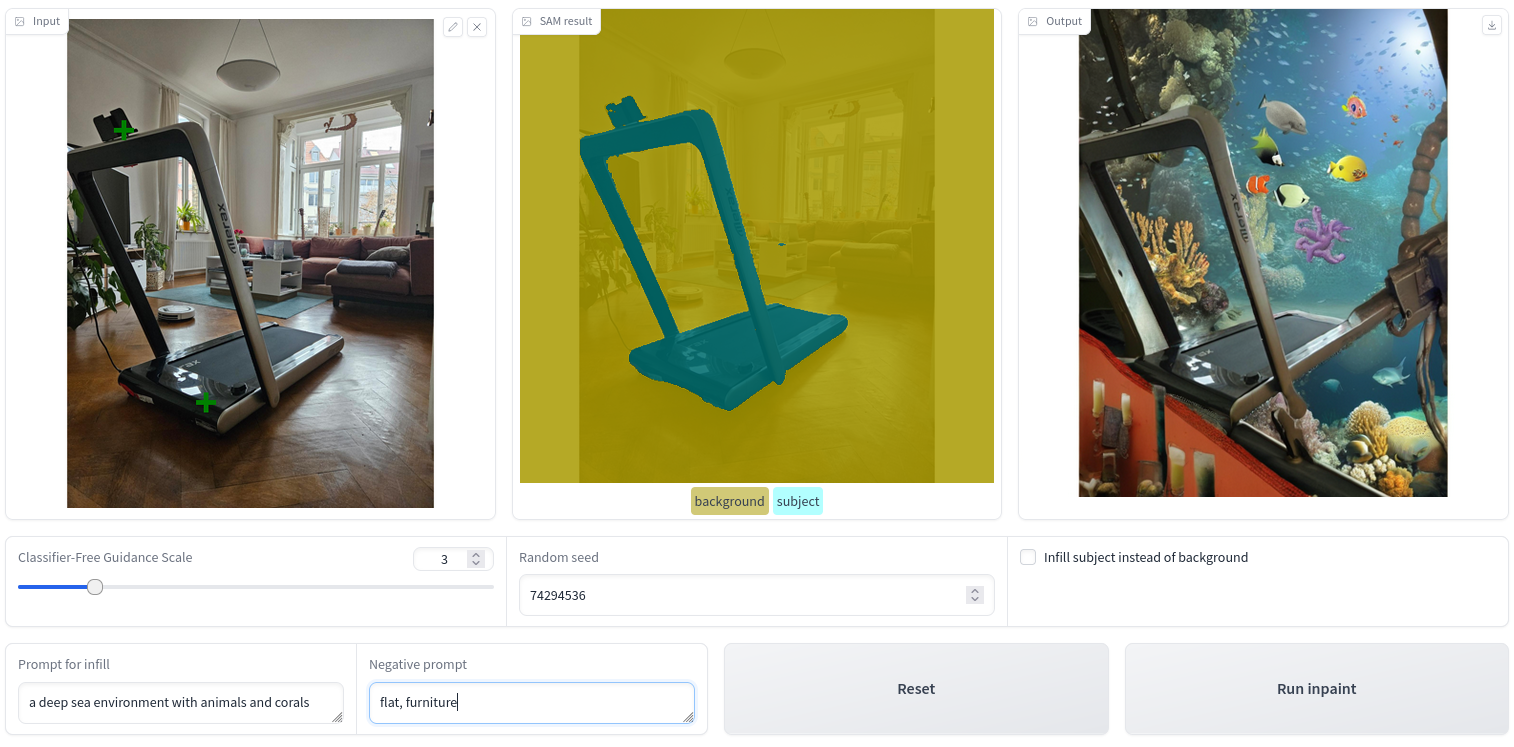

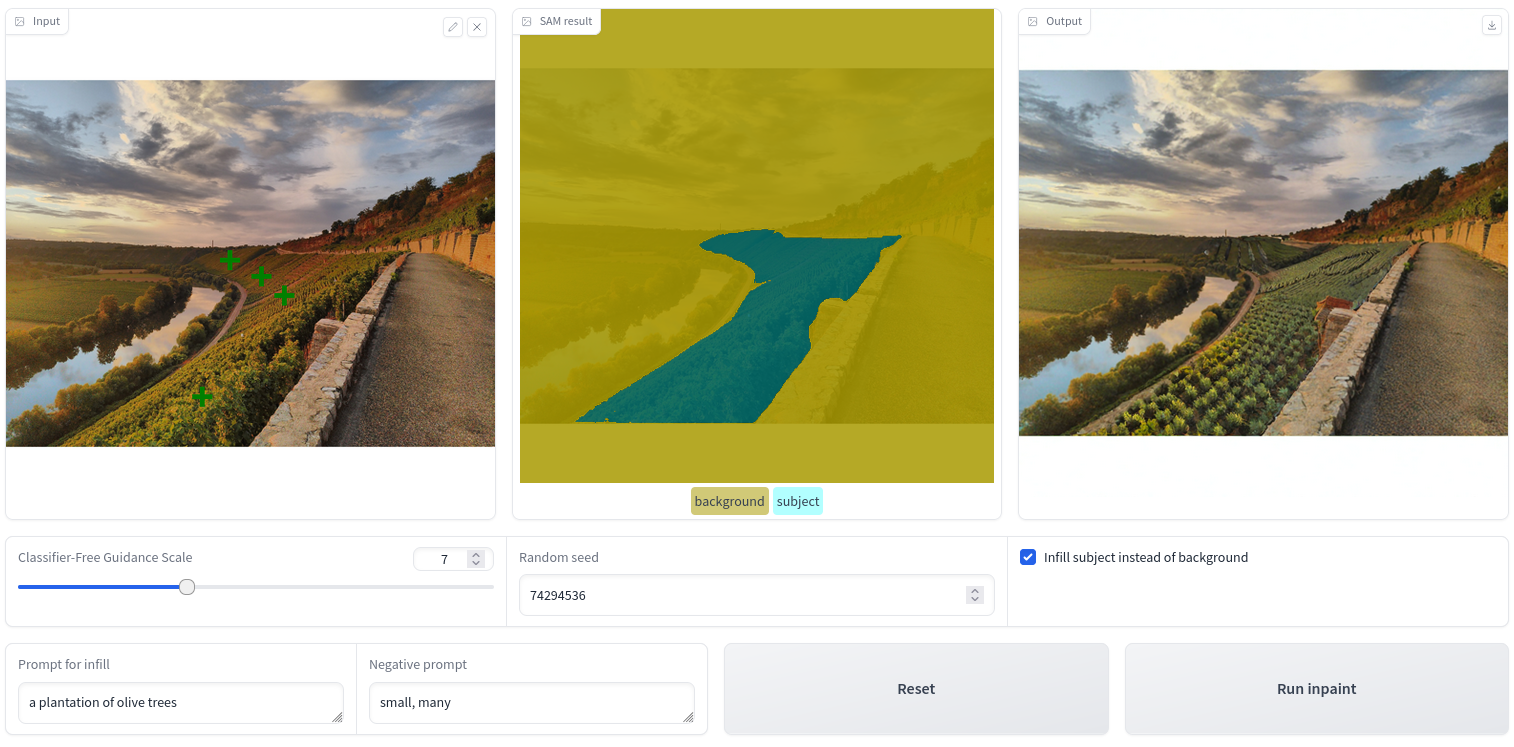